In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

[Reference](https://willcox-research-group.github.io/rom-operator-inference-Python3/source/tutorials/basics.html#sec-tutorial)

:::{admonition} Governing Equations
:class: attention

Let $\Omega = [0,L]\subset \mathbb{R}$ be the spatial domain indicated by the variable $x$, and let $[0,T]\subset\mathbb{R}$ be the time domain with variable $t$. We consider the one-dimensional heat equation with non-homogeneous Dirichlet boundary conditions,

\begin{align*}
    &\frac{\partial}{\partial t} q(x,t;\mu) = \mu\frac{\partial^2}{\partial x^2}q(x,t;\mu)+  u(t, x) + \eta(t, x)
    & x &\in\Omega,\quad t\in[0,T],
    \\
    &q(0,t;\mu) = q(L,t;\mu) = u(t)
    & t &\in[0,T],
    \\
    &q(x,0;\mu) = \big(e^{\alpha(x - 1)} + e^{-\alpha x} - e^{-\alpha}\big)u(0)
    & x &\in \Omega,
\end{align*}

where the constant $\mu > 0$ is the thermal diffusivity, $\alpha>0$ is constant, and $q(x,t;\mu)$ is the unknown state variable. This is a model for a one-dimensional rod conducting heat with a fixed initial heat profile. The temperature at the ends of the rod are governed by the input function $u(t)$, but  heat is allowed to diffuse through the rod and flow out at the ends of the domain. We aim to numerically solve for $q(x,t;\mu)$ efficiently for all $t \in [0,T]$ and/or for various choices of $u(t)$ and $\mu$.
:::

We use a centered finite difference approximation for the spatial derivative to arrive at a first-order system, this time of the form

$$
    \frac{\text{d}}{\text{d}t}\mathbf{q}(t;\mu)
    = \mathbf{A}(\mu)\mathbf{q}(t;\mu) + \mathbf{B}(\mu)u(t) + \mathbf{D}(\mu) \eta(t),
    \qquad
    \mathbf{q}(0;\mu)
    = \mathbf{q}_0.
$$ (eq_heat_fom_parametric)

:::{dropdown} Discretization details

We take an equidistant grid $\{x_i\}_{i=0}^{n+1} \subset \Omega$,

\begin{align*}
    0 &= x_0 < x_1 < \cdots < x_n < x_{n+1} = L
    &
    &\text{and}
    &
    \delta x &= \frac{L}{n+1} = x_{i+1} - x_{i},\quad i=1,\ldots,n-1.
\end{align*}

The boundary conditions prescribe $q(x_0,t) = q(x_{n+1},t) = u(t)$. Our goal is to compute $q(x,t)$ at the interior spatial points $x_{1},x_{2},\ldots,x_{n}$ for various $t\in[0,T]$, so we consider the state vector $\mathbf{q}(t) = [~q(x_{1}, t)~\cdots~q(x_{n}, t)~]^{\top}\in\mathbb{R}^n$ and derive a system governing the evolution of $\mathbf{q}(t)$ in time.

Approximating the spatial derivative with a central finite difference approximation,

$$
    \frac{\partial^2}{\partial x^2}q(x,t)
    \approx \frac{q(x-\delta x,t) - 2q(x,t) + q(x+\delta x,t)}{(\delta x)^2},
$$

we arrive at the following matrices for the full-order model.

$$
    \mathbf{A}(\mu) = \frac{\mu}{(\delta x)^2}\left[\begin{array}{ccccc}
        -2 & 1 & & & \\
        1 & -2 & 1 & & \\
        & \ddots & \ddots & \ddots & \\
        & & 1 & -2 & 1 \\
        & & & 1 & -2 \\
    \end{array}\right] \in\mathbb{R}^{n\times n},
    \qquad
    \mathbf{B}(\mu) = \frac{\mu}{(\delta x)^2}\left[\begin{array}{c}
        1 \\ 0 \\ \vdots \\ 0 \\ 1
    \end{array}\right]\in\mathbb{R}^{n}.
$$
:::

The state $\mathbf{q}(t;\mu)$ implicity depends on the parameter $\mu$ because the operators $\mathbf{A}(\mu)$ and $\mathbf{B}(\mu)$, $\mathbf{\mu}$ are parameterized by $\mu$.
For now, we set $\mu = 1$ and simply write

$$
    \frac{\text{d}}{\text{d}t}\mathbf{q}(t)
    = \mathbf{A}\mathbf{q}(t) + \mathbf{B}u(t) + \mathbf{D} \eta(t),
    \qquad
    \mathbf{q}(0)
    = \mathbf{q}_0.
$$

This is the _full-order model_ (FOM), which we will use to generate training data for the time domain $[0, T'] \subset [0, T]$.

In [16]:
# Matplotlib customizations.
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", dpi=300, figsize=(9, 3))
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.rc("text", usetex=True)

# Pandas display options.
pd.options.display.float_format = "{:.4%}".format

In [15]:
# Construct the spatial domain.
L = 1                           # Spatial domain length.
n = 2**7 - 1                    # Spatial grid size.
x_all = np.linspace(0, L, n+2)  # Full spatial grid.
x = x_all[1:-1]                 # Interior spatial grid (where q is unknown).
dx = x[1] - x[0]                # Spatial resolution.

# Construct the temporal domain.
t0, tf = 0, 1                   # Initial and final time.
k = tf*1000 + 1                 # Temporal grid size.
t = np.linspace(t0, tf, k)      # Temporal grid.
dt = t[1] - t[0]                # Temporal resolution.

print(f"Spatial step size δx = {dx}")
print(f"Temporal step size δt = {dt}")

Spatial step size δx = 0.0078125
Temporal step size δt = 0.001


In [44]:
# Construct the full-order state matrix A.
dx2inv = 1 / dx**2
diags = np.array([1, -2, 1]) * dx2inv
A = sparse.diags(diags, [-1, 0, 1], (n, n))
Ad = np.array(A.todense() )
# Construct the full-order input matrix B.
B = np.zeros_like(x)
B[0], B[-1] = dx2inv, dx2inv

# Construct the full-order input matrix D
D = np.ones_like(x)
D[0], D[-1] = dx2inv, dx2inv

# Output Transmission Matrices, C and E:
C = np.ones_like(x)
E = np.ones_like(x)

In [45]:
type(Ad)

numpy.ndarray

In [51]:
x = np.arange(1, 7)
y = np.kron(x, x) 
y.shape, len(np.unique(y))

((36,), 18)

In [4]:
def plot_heat_data(Z, title, ax=None):
    """Visualize temperature data in space and time."""
    if ax is None:
        _, ax = plt.subplots(1, 1)

    # Plot a few snapshots over the spatial domain.
    sample_columns = [0, 2, 5, 10, 20, 40, 80, 160, 320]
    color = iter(plt.cm.viridis_r(np.linspace(.05, 1, len(sample_columns))))

    leftBC, rightBC = [0], [0]
    for j in sample_columns:
        q_all = np.concatenate([leftBC, Z[:,j], rightBC])
        ax.plot(x_all, q_all, color=next(color), label=fr"$q(x,t_{{{j}}})$")

    ax.set_xlim(x_all[0], x_all[-1])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$q(x,t)$")
    ax.legend(loc=(1.05, .05))
    ax.set_title(title)

shape of Q: (127, 1001)


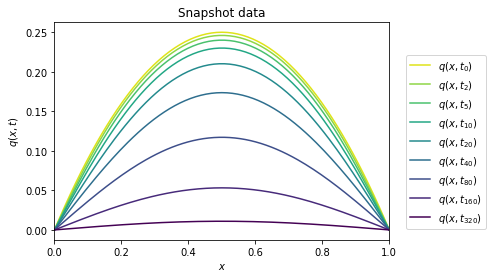

In [5]:
# Compute snapshots by solving the full-order model with SciPy.
Q = solve_ivp(fom, [t0,tf], q0, t_eval=t, method="BDF", max_step=dt).y

print(f"shape of Q: {Q.shape}")

plot_heat_data(Q, "Snapshot data")

In [8]:
import opinf

basis = opinf.pre.PODBasis().fit(Q, r=2)                # Construct the low-dimensional basis.
Qdot = opinf.pre.ddt(Q, dt, order=6)                    # Calculate the time derivative matrix.
rom = opinf.ContinuousOpInfROM(modelform="A")           # Define the model structure.
solver = opinf.lstsq.L2Solver(regularizer=1e-2)         # Select a least-squares solver with regularization.
rom.fit(basis, Q, Qdot, solver=solver)                  # Construct the ROM by solving the operator inference.
Q_ROM = rom.predict(q0, t, method="BDF", max_step=dt)   # Simulate the ROM.
opinf.post.frobenius_error(Q, Q_ROM)[1]                 # Calculate the relative error of the ROM simulation.

0.0008696953742698876

In [9]:
rom 

Reduced-order model structure: dq / dt = Aq(t)
Full-order dimension    n = 127
Reduced-order dimension r = 2